In [52]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# 横型ブラインドの斜入射特性を計算するモジュール

### 1. 平板での計算

スラット材の形状とスラットの日射反射率から任意のプロファイル角における横型ブラインドの日射透過率及び日射反射率を計算する。

### 入力値  

$ W $ ：スラット幅 (m)  
$ d $ ：スラット高さ (m)  
$ S $ ：スラット間隔 (m)  
$ \rho_{upper,S} $：スラット材上面の日射反射率（鏡面反射成分）  
$ \rho_{upper,D} $：スラット材上面の日射反射率（拡散反射成分）  
$ \rho_{lower,S} $：スラット材下面の日射反射率（鏡面反射成分）  
$ \rho_{lower,D} $：スラット材下面の日射反射率（拡散反射成分）  
$ \psi $：スラット角 (°)  
$ \phi $：プロファイル角 (°)  

### 出力値
$ \tau_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$ W $・$ d $・$ S $・$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $・$ \psi $・$ \phi $の組み合わせを1つの変数（タプル）で表し"hbl_input"とする。  
$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $の値は0.0以上1.0以下の値をとる。  
$ \psi $・$ \phi $の値は-90°以上90°以下の値をとる。  

In [25]:
class hbl_input(namedtuple('hbl_input','hbl_W hbl_d hbl_S hbl_REFUS hbl_REFUD hbl_REFLS hbl_REFLD hbl_psi')):
    __slots__ = ()

#hbl_W：スラット幅 (m)
#hbl_d：スラット高さ (m) 
#hbl_S：スラット間隔 (m) 
#hbl_REFUS：スラット材上面の日射反射率（鏡面反射成分）
#hbl_REFUD：スラット材上面の日射反射率（拡散反射成分）
#hbl_REFLS：スラット材下面の日射反射率（鏡面反射成分）
#hbl_REFLD：スラット材下面の日射反射率（拡散反射成分）
#hbl_psi：スラット角 (°) 

$ \begin{align} Q_{m,(0)} = I･\cos \phi･\Delta L_{m} \end{align}$ ････････････････････････････････････････････ (1)

In [ ]:
#日射の微小分割
def hblind_ang_prop(L, phi): #phiは、プロファイル角

    I = 1.
    M = 100
    K1 = 10
    K2 = 10
    K3 = 10
    K4 = 10
    
    dLm = L.hbl_S / M
    Qm[0] = I * math.cos(math.radians(phi)) * dLm
    
    for m in range(M):
        p[0, m] = np.array([0, S / M * (m + 0.5)])
    s[0] = np.array([1, - math.tan(radians(phi))])   #入射光の方向ベクトル
    
    
    
    return r_TRSf, r_TRSb, r_REFf, r_REFb    

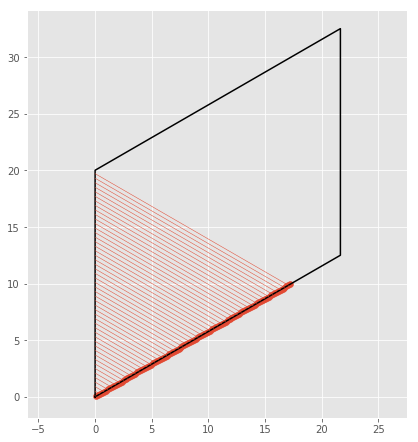

In [171]:
S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
M = 100                              #入射開口の微小線分要素分割数
phi = 30.                            #プロファイル角(°)
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数
psi = 30.                            #スラット角(°)

p = np.empty((M, 2), dtype=object)
s = np.empty((M, 2), dtype=object)
for m in range(M):
    #日射の始点の位置ベクトル(0回目)
    p[m] = [0, S / M * (m + 0.5)]
    #日射の方向ベクトル(0回目)
    s[m] = [1, - math.tan(math.radians(phi))]

Kall = np.sum(K)
#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if i <= K[0]:                            #A-B間
        q[i] = [W / K[0] * i * math.cos(math.radians(psi)), 
                W / K[0] * i * math.sin(math.radians(psi))]
    elif i <= (K[0] + K[1]):                 #B-C間
        q[i] = [W * math.cos(math.radians(psi)), 
                W * math.sin(math.radians(psi)) + S / K[1] * (i - K[0])]
    elif i <= (K[0] + K[1] + K[2]):          #C-D間
        q[i] = [W * math.cos(math.radians(psi))     - W / K[2] * (i - K[0] - K[1]) * math.cos(math.radians(psi)), 
                W * math.sin(math.radians(psi)) + S - W / K[2] * (i - K[0] - K[1]) * math.sin(math.radians(psi))]
    elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
        q[i] = [0, S - S / K[3] * (i - K[0] - K[1] - K[2])]

#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    if i < K[0]:                             #A-B間
        v[i] = [W / K[0] * math.cos(math.radians(psi)), 
                W / K[0] * math.sin(math.radians(psi))]
    elif i < (K[0] + K[1]):                  #B-C間
        v[i] = [0, S / K[1]]
    elif i < (K[0] + K[1] + K[2]):           #C-D間
        v[i] = [-W / K[2] * math.cos(math.radians(psi)), 
                -W / K[2] * math.sin(math.radians(psi))]
    elif i < (K[0] + K[1] + K[2] + K[3]):    #D-A間
        v[i] = [0, -S / K[3]]

isp = np.empty((M, 2), dtype=object)
for m in range(M):
    for i in range(Kall):
        deno = v[i][1] * s[m][0] - v[i][0] * s[m][1]
        if deno != 0:
            a = (v[i][0] * (p[m][1] - q[i][1]) - v[i][1] * (p[m][0] - q[i][0])) / deno
            b = (s[m][0] * (p[m][1] - q[i][1]) - s[m][1] * (p[m][0] - q[i][0])) / deno
            if 0 < a and 0 <= b and b < 1:
                isp[m] = q[i] + b * v[i]

#グラフの描画                
gx = np.empty((M, 2), dtype=object)
gy = np.empty((M, 2), dtype=object)
for m in range(0, M, 2):                
    gx[m] = [p[m][0], isp[m][0]]
    gy[m] = [p[m][1], isp[m][1]]    

fig = plt.figure(figsize = (15, 7.5))
plt.style.use('ggplot')
ax = fig.add_subplot(1, 2, 1)
ax.plot(q[:, 0], q[:, 1], color='k')
for m in range(M):
    ax.plot(gx[m], gy[m], color='C0', linewidth=0.5)
ax.scatter(isp[:, 0], isp[:, 1], color='C0')
plt.axis('equal')

plt.show()
        
        
#for m in range(M):
#    print(m, isp[m])



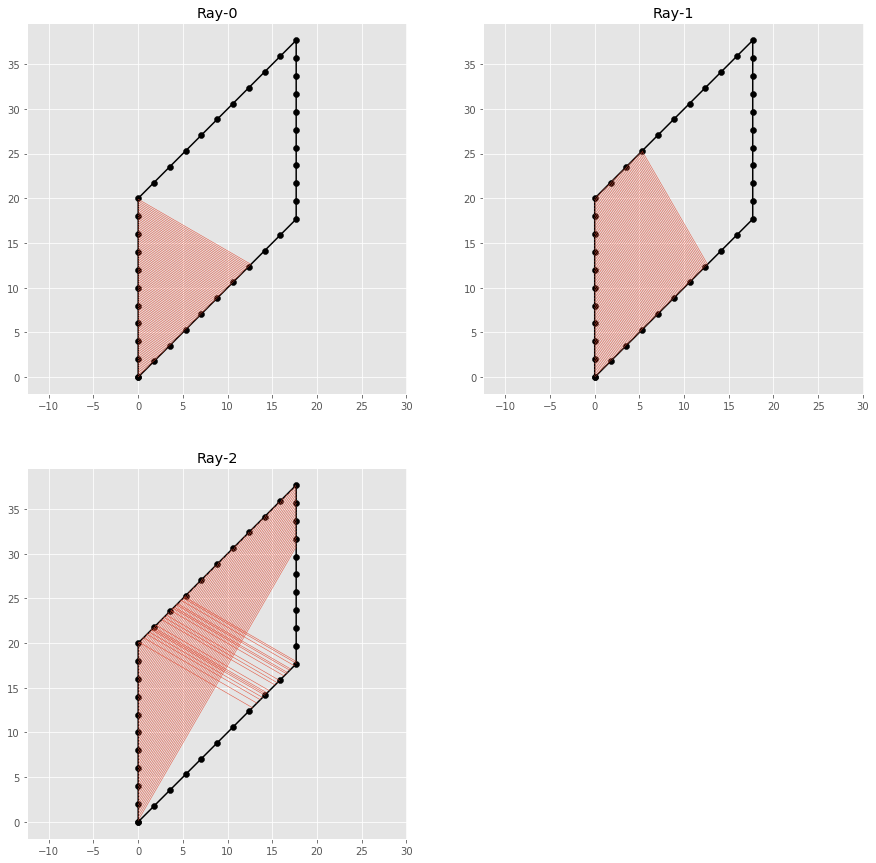

0 0 [0 0.1] [0.8660254037844387 -0.49999999999999994]
1 0 [0 0.30000000000000004] [0.8660254037844387 -0.49999999999999994]
2 0 [0 0.5] [0.8660254037844387 -0.49999999999999994]
3 0 [0 0.7000000000000001] [0.8660254037844387 -0.49999999999999994]
4 0 [0 0.9] [0.8660254037844387 -0.49999999999999994]
5 0 [0 1.1] [0.8660254037844387 -0.49999999999999994]
6 0 [0 1.3] [0.8660254037844387 -0.49999999999999994]
7 0 [0 1.5] [0.8660254037844387 -0.49999999999999994]
8 0 [0 1.7000000000000002] [0.8660254037844387 -0.49999999999999994]
9 0 [0 1.9000000000000001] [0.8660254037844387 -0.49999999999999994]
10 0 [0 2.1] [0.8660254037844387 -0.49999999999999994]
11 0 [0 2.3000000000000003] [0.8660254037844387 -0.49999999999999994]
12 0 [0 2.5] [0.8660254037844387 -0.49999999999999994]
13 0 [0 2.7] [0.8660254037844387 -0.49999999999999994]
14 0 [0 2.9000000000000004] [0.8660254037844387 -0.49999999999999994]
15 0 [0 3.1] [0.8660254037844387 -0.49999999999999994]
16 0 [0 3.3000000000000003] [0.86602540

59 2 [0.22378961927640861 20.22378961927641] [0.86602540378443871 -0.49999999999999994]
60 2 [0.35058453851952209 20.350584538519524] [0.86602540378443871 -0.49999999999999994]
61 2 [0.4773794577626338 20.477379457762634] [0.86602540378443871 -0.49999999999999994]
62 2 [0.60417437700574528 20.604174377005744] [0.86602540378443871 -0.49999999999999994]
63 2 [0.73096929624885698 20.730969296248858] [0.86602540378443871 -0.49999999999999994]
64 2 [0.85776421549197124 20.857764215491972] [0.86602540378443871 -0.49999999999999994]
65 2 [0.98455913473508339 20.984559134735083] [0.86602540378443871 -0.49999999999999994]
66 2 [1.1113540539781956 21.111354053978197] [0.86602540378443871 -0.49999999999999994]
67 2 [1.2381489732213078 21.238148973221307] [0.86602540378443871 -0.49999999999999994]
68 2 [1.3649438924644202 21.364943892464421] [0.86602540378443871 -0.49999999999999994]
69 2 [1.4917388117075323 21.491738811707531] [0.86602540378443871 -0.49999999999999994]
70 2 [1.618533730950646 21.

In [266]:
S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
M = 100                              #入射開口の微小線分要素分割数
phi = 30.                            #プロファイル角(°)
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
psi = 45.                            #スラット角(°)
L = 100                              #最大反射回数

#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if i <= K[0]:                            #A-B間
        q[i] = [W / K[0] * i * math.cos(math.radians(psi)), 
                W / K[0] * i * math.sin(math.radians(psi))]
    elif i <= (K[0] + K[1]):                 #B-C間
        q[i] = [W * math.cos(math.radians(psi)), 
                W * math.sin(math.radians(psi)) + S / K[1] * (i - K[0])]
    elif i <= (K[0] + K[1] + K[2]):          #C-D間
        q[i] = [W * math.cos(math.radians(psi))     - W / K[2] * (i - K[0] - K[1]) * math.cos(math.radians(psi)), 
                W * math.sin(math.radians(psi)) + S - W / K[2] * (i - K[0] - K[1]) * math.sin(math.radians(psi))]
    elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
        q[i] = [0, S - S / K[3] * (i - K[0] - K[1] - K[2])]

#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    if i < K[0]:                             #A-B間
        v[i] = [W / K[0] * math.cos(math.radians(psi)), 
                W / K[0] * math.sin(math.radians(psi))]
    elif i < (K[0] + K[1]):                  #B-C間
        v[i] = [0, S / K[1]]
    elif i < (K[0] + K[1] + K[2]):           #C-D間
        v[i] = [-W / K[2] * math.cos(math.radians(psi)), 
                -W / K[2] * math.sin(math.radians(psi))]
    elif i < (K[0] + K[1] + K[2] + K[3]):    #D-A間
        v[i] = [0, -S / K[3]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
while l <= 2:
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][0] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [math.cos(math.radians(phi)), -math.sin(math.radians(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            s[m][l] = -s[m][l-1] + 2 * np.dot(s[m][l-1], v[ipi[m]]) * v[ipi[m]] / (v[ipi[m]][0] ** 2. + v[ipi[m]][1] ** 2.)
            #print (s[m][l-1], s[m][l])
            
    ipi = np. empty(M, dtype=object)
    for m in range(M):
        for i in range(Kall):
            deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
            if deno != 0:
                a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno
                if 0 < a and 0 <= b and b < 1:
                    p[m][l + 1] = q[i] + b * v[i]
                    ipi[m] = i

    l += 1

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 1):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()
        
for ll in range(l):        
    for m in range(M):
        #print(m, ll, p[m][ll], p[m][ll+1])
        print(m, ll, p[m][ll], s[m][ll])



In [163]:
phi = 45. #hbl_phi：プロファイル角 (°)
hbl_in = hbl_input(24.6, 2.2, 21.5, 0.03, 0.70, 0.03, 0.70, 45.)



for j in range(-90, 91):
    if j == -90:
        phi = -89.9
    elif j == 90:
        phi = 89.9
    else:
        phi = j
    
    hbl_result[0][j] = phi
    hbl_result[1][j] = hbl_TRSf(hbl_in, phi)
    hbl_result[2][j] = hbl_TRSb(hbl_in, phi)
    hbl_result[3][j] = hbl_REFf(hbl_in, phi)
    hbl_result[4][j] = hbl_REFb(hbl_in, phi)
    
print (hbl_result)

NameError: name 'hbl_input' is not defined

#### 入射角φの日射透過率及び日射反射率の計算

入射角によって日射特性が変化しないロールスクリーンの日射透過率及び日射反射率の計算方法を以下に示す。  

$ \begin{align}\tau_{\phi,f} = \tau_{0,f}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-a)

$ \begin{align}\tau_{\phi,b} = \tau_{0,b}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-b)

$ \begin{align}\rho_{\phi,f} =\rho_{0,f}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-c)

$ \begin{align}\rho_{\phi,b} =\rho_{0,b}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-d)  

In [26]:
# 入射角φの日射透過率及び日射反射率の計算
def role_TRSf(L, phi):
    return L.role_TRS0f

def role_TRSb(L, phi):
    return L.role_TRS0b
    
def role_REFf(L, phi):
    return L.role_REF0f
    
def role_REFb(L, phi):
    return L.role_REF0b

#### Example

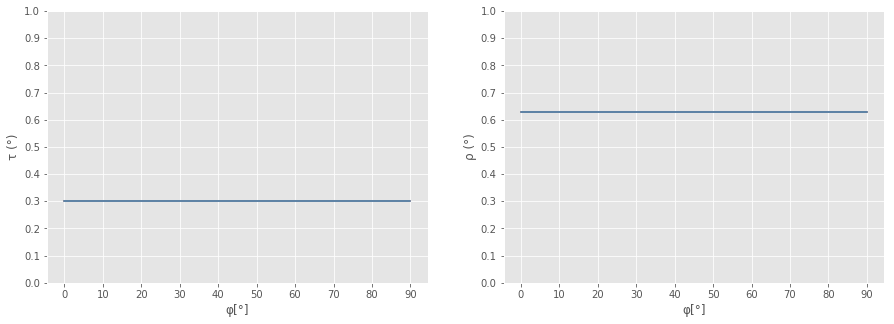

In [27]:
role_result = np.zeros((5,91))
rl_in = role_input(0.3, 0.3, 0.63, 0.63)

for j in range(0, 91):
    phi = j
    role_result[0][j] = phi
    role_result[1][j] = role_TRSf(rl_in, phi)
    role_result[2][j] = role_TRSb(rl_in, phi)
    role_result[3][j] = role_REFf(rl_in, phi)
    role_result[4][j] = role_REFb(rl_in, phi)
   
np.savetxt('role_result.csv', np.transpose(role_result), fmt='%.10f', delimiter=',')

#グラフの描画
graph_num = 2
ax = np.empty(graph_num, dtype = np.object)
fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
plt.style.use('ggplot')

gpc = ['C0', 'C1']
gxd = [[role_result[0][0:91], role_result[0][0:91]], [role_result[0][0:91], role_result[0][0:91]]]
gyd = [[role_result[1][0:91], role_result[2][0:91]], [role_result[3][0:91], role_result[4][0:91]]]
gxl = 'φ[°]'
gyl = ['τ (°)', 'ρ (°)']
gxt = [10 * i for i in range(10)]
gyt = [0.1 * i for i in range(11)]
    
for i in range(graph_num):   
    ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
    for j in range(2):
        ax[i].plot(gxd[i][j], gyd[i][j], color = gpc[j])
    ax[i].set_xticks(gxt)
    ax[i].set_yticks(gyt)
    ax[i].set_xlabel(gxl, fontsize = 12)
    ax[i].set_ylabel(gyl[i], fontsize = 12)

plt.show()